In [1]:
import numpy as np
import pandas as pd
import warnings
import gc
from tqdm import tqdm_notebook as tqdm
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import roc_auc_score
warnings.filterwarnings("ignore")
gc.enable()

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)

In [3]:
train_raw = pd.read_csv('./data/train.csv')
test_raw = pd.read_csv('./data/test.csv')
train_raw.shape, test_raw.shape

((200000, 202), (200000, 201))

In [ ]:
# del train, test, clf, data
# gc.collect()

In [4]:
train = train_raw.copy()
test = test_raw.copy()

In [5]:
col_list = train.columns[2:]

In [6]:
train_0 = train[train.target == 0]
train_1 = train[train.target == 1]

In [7]:
pb_idx = np.load('./data_temp/public_LB.npy')
pv_idx = np.load('./data_temp/private_LB.npy')

In [8]:
test_pb = test.iloc[pb_idx].sort_index().copy()
test_pv = test.iloc[pv_idx].sort_index().copy()

test_real = test_pb.append(test_pv)

In [9]:
data = train.append(test_real)[['ID_code', 'target'] + col_list.tolist()]

# Extract Unique Value in All Data

## filter

In [10]:
## filter

unique_df = data[['ID_code']]
con_df = data[['ID_code']]

for col in tqdm(col_list):
    unique_df[col] = data[col].map(((data[col].value_counts() == 1) * 1).to_dict())
    con_df[col] = data[col].map((~(data[col].value_counts() == 1) * 1).to_dict())

## make data

In [11]:
for col in tqdm(col_list):
    data[col + '_unique'] = data[col] * unique_df[col]
    data[col + '_con'] = data[col] * con_df[col]

In [12]:
for col in tqdm(col_list):
    data.loc[data[col + '_unique']==0, col + '_unique'] = np.nan
    data.loc[data[col + '_con']==0, col + '_con'] = np.nan

In [13]:
for col in tqdm(col_list):
    data[col + '_con_multi_counts'] = data[col + '_con'] * data[col].map(data[col].value_counts().to_dict())

# 정상 Modeling

In [14]:
data.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,var_0_unique,var_0_con,var_1_unique,var_1_con,var_2_unique,var_2_con,var_3_unique,var_3_con,var_4_unique,var_4_con,var_5_unique,var_5_con,var_6_unique,var_6_con,var_7_unique,var_7_con,var_8_unique,var_8_con,var_9_unique,var_9_con,var_10_unique,var_10_con,var_11_unique,var_11_con,var_12_unique,var_12_con,var_13_unique,var_13_con,var_14_unique,var_14_con,var_15_unique,var_15_con,var_16_unique,var_16_con,var_17_unique,var_17_con,var_18_unique,var_18_con,var_19_unique,var_19_con,var_20_unique,var_20_con,var_21_unique,var_21_con,var_22_unique,var_22_con,var_23_unique,var_23_con,...,var_175_unique,var_175_con,var_176_unique,var_176_con,var_177_unique,var_177_con,var_178_unique,var_178_con,var_179_unique,var_179_con,var_180_unique,var_180_con,var_181_unique,var_181_con,var_182_unique,var_182_con,var_183_unique,var_183_con,var_184_unique,var_184_con,var_185_unique,var_185_con,var_186_unique,var_186_con,var_187_unique,var_187_con,var_188_unique,var_188_con,var_189_unique,var_189_con,var_190_unique,var_190_con,var_191_unique,var_191_con,var_192_unique,var_192_con,var_193_unique,var_193_con,var_194_unique,var_194_con,var_195_unique,var_195_con,var_196_unique,var_196_con,var_197_unique,var_197_con,var_198_unique,var_198_con,var_199_unique,var_199_con,var_0_con_multi_counts,var_1_con_multi_counts,var_2_con_multi_counts,var_3_con_multi_counts,var_4_con_multi_counts,var_5_con_multi_counts,var_6_con_multi_counts,var_7_con_multi_counts,var_8_con_multi_counts,var_9_con_multi_counts,var_10_con_multi_counts,var_11_con_multi_counts,var_12_con_multi_counts,var_13_con_multi_counts,var_14_con_multi_counts,var_15_con_multi_counts,var_16_con_multi_counts,var_17_con_multi_counts,var_18_con_multi_counts,var_19_con_multi_counts,var_20_con_multi_counts,var_21_con_multi_counts,var_22_con_multi_counts,var_23_con_multi_counts,var_24_con_multi_counts,var_25_con_multi_counts,var_26_con_multi_counts,var_27_con_multi_counts,var_28_con_multi_counts,var_29_con_multi_counts,var_30_con_multi_counts,var_31_con_multi_counts,var_32_con_multi_counts,var_33_con_multi_counts,var_34_con_multi_counts,var_35_con_multi_counts,var_36_con_multi_counts,var_37_con_multi_counts,var_38_con_multi_counts,var_39_con_multi_counts,var_40_con_multi_counts,var_41_con_multi_counts,var_42_con_multi_counts,var_43_con_multi_counts,var_44_con_multi_counts,var_45_con_multi_counts,var_46_con_multi_counts,var_47_con_multi_counts,var_48_con_multi_counts,var_49_con_multi_counts,var_50_con_multi_counts,var_51_con_multi_coun

In [102]:
train = data[~data.target.isna()]
test = data[data.target.isna()]

In [16]:
target = train['target']

In [17]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average': False,
    'boost': 'gbdt',
    'feature_fraction_seed': 47,
    'feature_fraction': 0.041,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 2,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1,
    'num_threads': 8
}

* 0.92288

In [19]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [c for c in train.columns if c not in ['ID_code', 'target']]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target.values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 100000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=4000, early_stopping_rounds = 400)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits

    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    print("CV score: {:<8.5f}".format(roc_auc_score(target.values[val_idx], oof_lgb[val_idx])))
            
print("CV score: {:<8.5f}".format(roc_auc_score(target.values, oof_lgb)))

fold n°0
Training until validation scores don't improve for 400 rounds.
[4000]	training's auc: 0.882404	valid_1's auc: 0.875258
[8000]	training's auc: 0.907392	valid_1's auc: 0.898983
[12000]	training's auc: 0.91832	valid_1's auc: 0.908665
[16000]	training's auc: 0.924571	valid_1's auc: 0.914166
[20000]	training's auc: 0.928487	valid_1's auc: 0.917378
[24000]	training's auc: 0.931132	valid_1's auc: 0.919339
[28000]	training's auc: 0.933087	valid_1's auc: 0.920628
[32000]	training's auc: 0.934601	valid_1's auc: 0.921333
[36000]	training's auc: 0.935888	valid_1's auc: 0.921731
Early stopping, best iteration is:
[37615]	training's auc: 0.936309	valid_1's auc: 0.921915
CV score: 0.92191 
fold n°1
Training until validation scores don't improve for 400 rounds.
[4000]	training's auc: 0.882515	valid_1's auc: 0.877809
[8000]	training's auc: 0.906912	valid_1's auc: 0.901161
[12000]	training's auc: 0.917933	valid_1's auc: 0.910564
[16000]	training's auc: 0.924232	valid_1's auc: 0.915623
[20000]	t

## 실험 1)

In [100]:
temp_0_id = oof[(oof.pred > 0.2) & (oof.target == 0)].ID_code
temp_1_id = oof[(oof.pred > 0.2) & (oof.target == 1)].ID_code

In [92]:
temp_0 = train[train.ID_code.isin(temp_0_id)].iloc[:6000]
# temp_1 = train[train.ID_code.isin(temp_1_id)]
temp_1 = train[train.ID_code.isin(temp_0_id)].iloc[6000:]

temp_0.target = 1
temp_1.target = 0

In [93]:
train = temp_0.append(temp_1).sort_index()

In [94]:
target = train['target']

In [95]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average': False,
    'boost': 'gbdt',
    'feature_fraction_seed': 47,
    'feature_fraction': 0.041,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 2,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1,
    'num_threads': 8
}

In [96]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
feature_importance = pd.DataFrame()

train_columns = [c for c in train.columns if c not in ['ID_code', 'target']]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target.values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 100000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=4000, early_stopping_rounds = 400)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    print("CV score: {:<8.5f}".format(roc_auc_score(target.values[val_idx], oof_lgb[val_idx])))
            
print("CV score: {:<8.5f}".format(roc_auc_score(target.values, oof_lgb)))

fold n°0
Training until validation scores don't improve for 400 rounds.
Early stopping, best iteration is:
[166]	training's auc: 0.606358	valid_1's auc: 0.509173
CV score: 0.50917 
fold n°1
Training until validation scores don't improve for 400 rounds.
Early stopping, best iteration is:
[2]	training's auc: 0.518905	valid_1's auc: 0.517681
CV score: 0.51768 
fold n°2
Training until validation scores don't improve for 400 rounds.
Early stopping, best iteration is:
[26]	training's auc: 0.546656	valid_1's auc: 0.532243
CV score: 0.53224 
fold n°3
Training until validation scores don't improve for 400 rounds.
Early stopping, best iteration is:
[221]	training's auc: 0.631352	valid_1's auc: 0.521929
CV score: 0.52193 
fold n°4
Training until validation scores don't improve for 400 rounds.
Early stopping, best iteration is:
[144]	training's auc: 0.607218	valid_1's auc: 0.523183
CV score: 0.52318 
CV score: 0.51030 


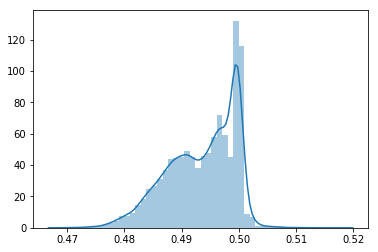

In [98]:
sns.distplot(oof_lgb)

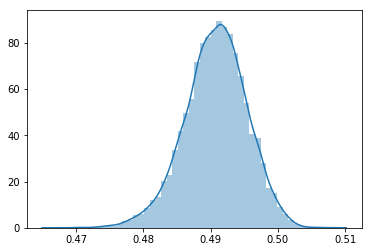

In [107]:
sns.distplot(clf.predict(temp_1[train_columns]))

In [104]:
temp_1 = train[train.ID_code.isin(temp_1_id)]

In [105]:
temp_1.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,var_0_unique,var_0_con,var_1_unique,var_1_con,var_2_unique,var_2_con,var_3_unique,var_3_con,var_4_unique,var_4_con,var_5_unique,var_5_con,var_6_unique,var_6_con,var_7_unique,var_7_con,var_8_unique,var_8_con,var_9_unique,var_9_con,var_10_unique,var_10_con,var_11_unique,var_11_con,var_12_unique,var_12_con,var_13_unique,var_13_con,var_14_unique,var_14_con,var_15_unique,var_15_con,var_16_unique,var_16_con,var_17_unique,var_17_con,var_18_unique,var_18_con,var_19_unique,var_19_con,var_20_unique,var_20_con,var_21_unique,var_21_con,var_22_unique,var_22_con,var_23_unique,var_23_con,...,var_175_unique,var_175_con,var_176_unique,var_176_con,var_177_unique,var_177_con,var_178_unique,var_178_con,var_179_unique,var_179_con,var_180_unique,var_180_con,var_181_unique,var_181_con,var_182_unique,var_182_con,var_183_unique,var_183_con,var_184_unique,var_184_con,var_185_unique,var_185_con,var_186_unique,var_186_con,var_187_unique,var_187_con,var_188_unique,var_188_con,var_189_unique,var_189_con,var_190_unique,var_190_con,var_191_unique,var_191_con,var_192_unique,var_192_con,var_193_unique,var_193_con,var_194_unique,var_194_con,var_195_unique,var_195_con,var_196_unique,var_196_con,var_197_unique,var_197_con,var_198_unique,var_198_con,var_199_unique,var_199_con,var_0_con_multi_counts,var_1_con_multi_counts,var_2_con_multi_counts,var_3_con_multi_counts,var_4_con_multi_counts,var_5_con_multi_counts,var_6_con_multi_counts,var_7_con_multi_counts,var_8_con_multi_counts,var_9_con_multi_counts,var_10_con_multi_counts,var_11_con_multi_counts,var_12_con_multi_counts,var_13_con_multi_counts,var_14_con_multi_counts,var_15_con_multi_counts,var_16_con_multi_counts,var_17_con_multi_counts,var_18_con_multi_counts,var_19_con_multi_counts,var_20_con_multi_counts,var_21_con_multi_counts,var_22_con_multi_counts,var_23_con_multi_counts,var_24_con_multi_counts,var_25_con_multi_counts,var_26_con_multi_counts,var_27_con_multi_counts,var_28_con_multi_counts,var_29_con_multi_counts,var_30_con_multi_counts,var_31_con_multi_counts,var_32_con_multi_counts,var_33_con_multi_counts,var_34_con_multi_counts,var_35_con_multi_counts,var_36_con_multi_counts,var_37_con_multi_counts,var_38_con_multi_counts,var_39_con_multi_counts,var_40_con_multi_counts,var_41_con_multi_counts,var_42_con_multi_counts,var_43_con_multi_counts,var_44_con_multi_counts,var_45_con_multi_counts,var_46_con_multi_counts,var_47_con_multi_counts,var_48_con_multi_counts,var_49_con_multi_counts,var_50_con_multi_counts,var_51_con_multi_coun

fold n°0
Training until validation scores don't improve for 400 rounds.
[4000]	training's auc: 0.774563	valid_1's auc: 0.689666
[8000]	training's auc: 0.811512	valid_1's auc: 0.719634
[12000]	training's auc: 0.832444	valid_1's auc: 0.735066
[16000]	training's auc: 0.845316	valid_1's auc: 0.743941
[20000]	training's auc: 0.853494	valid_1's auc: 0.74811
[24000]	training's auc: 0.860552	valid_1's auc: 0.752851
Early stopping, best iteration is:
[25337]	training's auc: 0.862166	valid_1's auc: 0.753912
CV score: 0.75391 
fold n°1
Training until validation scores don't improve for 400 rounds.
[4000]	training's auc: 0.777838	valid_1's auc: 0.700614
[8000]	training's auc: 0.8154	valid_1's auc: 0.726486
[12000]	training's auc: 0.835431	valid_1's auc: 0.739937
[16000]	training's auc: 0.847321	valid_1's auc: 0.74554
[20000]	training's auc: 0.855898	valid_1's auc: 0.750447
Early stopping, best iteration is:
[21286]	training's auc: 0.858256	valid_1's auc: 0.75178
CV score: 0.75178 
fold n°2
Training until validation scores don't improve for 400 rounds.
[4000]	training's auc: 0.776425	valid_1's auc: 0.706137
[8000]	training's auc: 0.814714	valid_1's auc: 0.733257
[12000]	training's auc: 0.833469	valid_1's auc: 0.74465
[16000]	training's auc: 0.84523	valid_1's auc: 0.751559
Early stopping, best iteration is:
[19538]	training's auc: 0.85305	valid_1's auc: 0.755062
CV score: 0.75506 
fold n°3
Training until validation scores don't improve for 400 rounds.
[4000]	training's auc: 0.782054	valid_1's auc: 0.686219
[8000]	training's auc: 0.816758	valid_1's auc: 0.706921
[12000]	training's auc: 0.838114	valid_1's auc: 0.719898
Early stopping, best iteration is:
[13499]	training's auc: 0.843248	valid_1's auc: 0.723342
CV score: 0.72334 
fold n°4
Training until validation scores don't improve for 400 rounds.
[4000]	training's auc: 0.778344	valid_1's auc: 0.692721
[8000]	training's auc: 0.816071	valid_1's auc: 0.718204
[12000]	training's auc: 0.83702	valid_1's auc: 0.730753
[16000]	training's auc: 0.84906	valid_1's auc: 0.739445
Early stopping, best iteration is:
[18035]	training's auc: 0.853834	valid_1's auc: 0.74156
CV score: 0.74156 
CV score: 0.74532 

In [88]:
oof = pd.read_csv('./data_temp/cv_0.92288.csv')

In [89]:
oof = oof[oof.ID_code.isin(train.ID_code)]

In [78]:
oof['pred_bb'] = oof_lgb

In [86]:
roc_auc_score(oof.target, oof.pred * oof.new_pred)

0.675722763305109

In [87]:
oof.to_csv('data_temp/')

,ID_code,target,pred,new_pred
1,train_1,0.0,0.563252,0.473170
13,train_13,1.0,0.767392,0.440654
29,train_29,1.0,0.249682,0.558801
51,train_51,0.0,0.262459,0.687186
63,train_63,1.0,0.690927,0.337631
65,train_65,1.0,0.950470,0.151851
71,train_71,1.0,0.726460,0.276908
75,train_75,0.0,0.349070,0.462882
90,train_90,0.0,0.628022,0.317887
99,train_99,1.0,0.703554,0.426159
